## Data preview and preparation

We first import the necessary libraries, including rdkit for generating molecular features and PyTorch Geometric's MoleculeNet for dataset access.

The dataset used in this project is the ESOL dataset, which contains solubility information for 1,128 small molecules. By leveraging the MoleculeNet API, the loading and preprocessing of the dataset are handled seamlessly, utilizing RDKit to generate consistent molecular features. This streamlined process ensures the dataset is ready for downstream tasks, such as graph-based learning using Graph Neural Networks.

In [6]:
# use rdkit to generate molecule features while importing dataset
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root='.', name="ESOL")
data

ESOL(1128)

The ESOL dataset represents molecules as graphs, with nodes as atoms and edges as bonds. Each graph contains node features, edge connections, and target properties. Key statistics include 1,128 samples, 32 nodes, and 68 edges per graph on average. The dataset is ideal for GNN-based regression tasks since the targets are continuous values. This graph representation ensures the dataset captures both atomic features and molecular connectivity.

In [10]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data[0].y.shape[0])
print("Dataset length: ", data.len())
print("Dataset sample: ", data[0])
print("Sample nodes: ", data[0].num_nodes)
print("Sample edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  1
Dataset length:  1128
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample nodes:  32
Sample edges:  68


### GNN Schematic

The following problem addresses the predictions based on the graph level. This means we have one y-label for the whole graph. 

Left: graph-level prediction. Right: node-level prediction.

<img src="../img/gnn_node_features.jpg" alt="drawing" width="700" height="350"/>

Each node represents an atom with descriptive features such as atomic number, hybridization state, and charge. The node feature matrix for a graph has a shape [num_nodes, num_features], where each row is a node's feature vector.

In [4]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

Edges represent bonds between atoms, stored efficiently in sparse COO format. Each edge is a pair of connected nodes, and the edge matrix has a shape [2, num_edges]. This format is computationally efficient for large, sparse graphs. Edges allow GNNs to propagate information between connected nodes, capturing molecular relationships and structure.

In [5]:
# Investigating the edges in sparse COO format
# Shape: [2, num_edges]
# i.e. node 0 is connected to node 1
# i.e. node 1 is connected to node 0
# i.e. node 1 is connected to node 2
# etc.
# NOTE: more efficient representation than adjacency matrix
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

Each sample in the dataset includes a target value y, the solubility of the corresponding molecule.

In [7]:
data[0].y

tensor([[-0.7700]])

### Converting SMILES to RDKit molecules - Visualizing molecules

The ESOL dataset includes molecules in the form of SMILES (Simplified Molecular Input Line Entry System) strings, a standard representation for chemical structures. Using RDKit, these SMILES strings are converted into molecular graph representations for visualization and further processing.

In [7]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

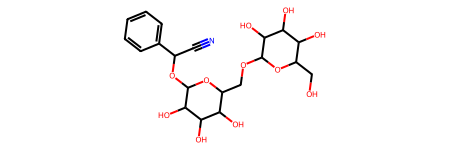

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

## Graph Convolutional Network (GCN) Implementation

The GCN model is designed to process molecular graph data using PyTorch Geometric. It includes an initial convolutional layer and three additional GCN layers, each with an embedding size of 64, to progressively learn hierarchical graph representations. A global pooling layer combines max and mean pooling to aggregate node features into a graph-level representation, which is passed through a linear layer to predict the solubility value.

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
  def __init__(self):
    # Init parent
    super(GCN, self).__init__()
    torch.manual_seed(197)

    # GCN layers
    self.initial_conv = GCNConv(data.num_features, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)

    # Output layer
    self.out = Linear(embedding_size*2, data.num_classes) # output shape 1 = regression
    # twice the size for accomodating the global pooling layer

  def forward(self, x, edge_index, batch_index):
    # First Conv layer
    hidden = self.initial_conv(x, edge_index)
    hidden = F.tanh(hidden) # activation function

    # Other Conv layers
    hidden = self.conv1(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv2(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv3(hidden, edge_index)
    hidden = F.tanh(hidden)

    # Global Pooling Layer (stack different aggregations)
    hidden = torch.cat([gmp(hidden, batch_index), 
                        gap(hidden, batch_index)], dim=1)
    # gmp = global max pooling
    # gap = gloabl average pooling
    # batch_index is used to select the relavent nodes for the pooling operation

    # Apply a final (linear) classifier.
    out = self.out(hidden)

    return out, hidden

### Graph Pooling

Aggregate all information of the final graph

![image.png](../img/gnn_global_pooling.jpg)

## Model Summary and Parameter Count

The GCN model comprises an initial convolutional layer, three additional GCN layers, and a linear output layer, resulting in 107,806 parameters. This design balances complexity and computational efficiency, ensuring the model is expressive enough to capture molecular graph features while remaining practical for training.

In [10]:
model = GCN()
print(model)
print("Model parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=734, bias=True)
)
Model parameters:  107806


## Training the GNN

### Batching with Graphs

Concatenate all node features in a large matrix. Combine each individual adjacency information into a large adjacency matrix or list.

NOTE: each individual graph is disconnected in the adjacency matrix, thus no information is shared between graphs.

![image.png](../img/gnn_batching.jpg)

The GNN is trained using the root MSE as the loss function and the Adam optimizer with a learning rate of 0.0007. The model is moved to a GPU if available, and the dataset is split 80:20 into training and testing sets. A DataLoader batches 64 graphs at a time, shuffling the data to ensure effective training.

In [11]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH,
                    shuffle=True) # 20% training

test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH,
                         shuffle=True) # 80% testing

The GNN is trained over 2,000 epochs using batches of graphs. For each batch, predictions are made, loss is computed using root mean squared error, and gradients are updated to minimize the loss. The training progress is logged every 100 epochs, showing the model's improvement in solubility prediction.

In [12]:
def train(data):
  # Enumerate over the data
  for batch in loader:
    # Use GPU
    batch.to(device)
    # Reset gradients
    optimizer.zero_grad()
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    # Calculating the loss and gradients
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward()
    # Update using the gradients
    optimizer.step()
  return loss, embedding

print("Start training...")
losses = []
for epoch in range(2000):
  loss, h = train(data)
  losses.append(loss)
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Train Loss {loss}")

Start training...
Epoch 0 | Train Loss 2.7871644496917725
Epoch 100 | Train Loss 0.6134768724441528
Epoch 200 | Train Loss 0.6100419163703918
Epoch 300 | Train Loss 0.7272345423698425
Epoch 400 | Train Loss 0.6576130390167236
Epoch 500 | Train Loss 0.2933323383331299
Epoch 600 | Train Loss 0.27025434374809265
Epoch 700 | Train Loss 0.7073735594749451
Epoch 800 | Train Loss 0.3695386052131653
Epoch 900 | Train Loss 0.3794698119163513
Epoch 1000 | Train Loss 0.5742687582969666
Epoch 1100 | Train Loss 0.2634759545326233
Epoch 1200 | Train Loss 0.2466924786567688
Epoch 1300 | Train Loss 0.44479894638061523
Epoch 1400 | Train Loss 0.42036837339401245
Epoch 1500 | Train Loss 0.23418088257312775
Epoch 1600 | Train Loss 0.3676973283290863
Epoch 1700 | Train Loss 0.21275733411312103
Epoch 1800 | Train Loss 0.34913355112075806
Epoch 1900 | Train Loss 0.14146572351455688


## Visualizing the Training Loss

<Axes: >

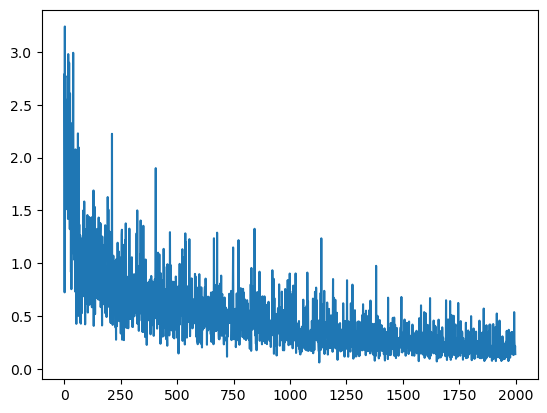

In [13]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

## Getting a test prediction

The model is tested on a batch of data in inference mode, and the real (y_real) and predicted (y_pred) solubility values are extracted and stored in a DataFrame for easy analysis. A scatter plot shows their alignment, with points near the diagonal indicating strong prediction accuracy.

In [14]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
  test_batch.to(device)
  pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
  df = pd.DataFrame()
  df["y_real"] = test_batch.y.tolist()
  df["y_pred"] = pred.tolist()

df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-3.79,-3.227950
1,-1.38,-0.949826
2,-2.12,-2.048041
3,-3.30,-3.713397
4,-4.89,-4.858216
...,...,...
59,-2.07,-2.587505
60,0.15,0.918960
61,-3.54,-4.002182
62,-2.54,-2.594413


<Axes: xlabel='y_real', ylabel='y_pred'>

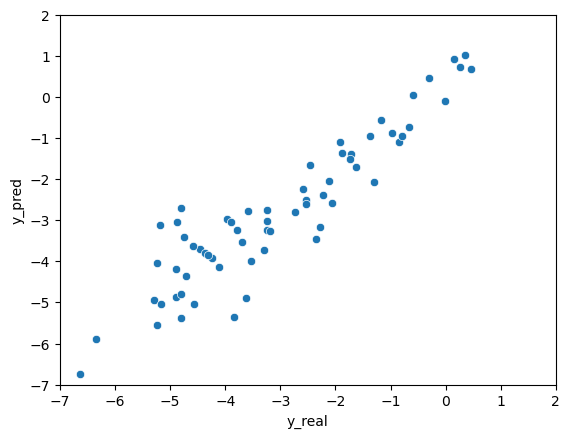

In [15]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

### Improving the model:
- Dropouts
- Other (more intelligent) Pooling Layers
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...